In [ ]:

import os
import numpy as np 
import xarray as xr
import matplotlib.pyplot as plt
from wrf import to_np, getvar, CoordPair, vertcross, get_cartopy, latlon_coords, interpline, interplevel
from netCDF4 import Dataset
from scipy.ndimage import gaussian_filter

In [ ]:
filename ='/Volumes/Ann/wrf_100%/wrfout_d03_2008-03-07_00:00:00'
ncfile = Dataset(filename)
geopotential = getvar(ncfile, "z")  # Geopotential height for model levels
lat, lon = latlon_coords(geopotential)  # Latitude and longitude
z = getvar(ncfile, "z") # 
pressure = getvar(ncfile, "pressure")  # Pressure levels
print(pressure.shape)
print(geopotential.shape)

(74, 1252, 1164)
(74, 1252, 1164)


In [24]:
data_dir = '/Volumes/Ann/wrf_100%/'
file_list = sorted([f for f in os.listdir(data_dir) if f.startswith("wrfout_d03")])
file_list = file_list[24:57]
print(file_list)
print(np.shape(file_list))

['wrfout_d03_2008-03-07_00:00:00', 'wrfout_d03_2008-03-07_00:15:00', 'wrfout_d03_2008-03-07_00:30:00', 'wrfout_d03_2008-03-07_00:45:00', 'wrfout_d03_2008-03-07_01:00:00', 'wrfout_d03_2008-03-07_01:15:00', 'wrfout_d03_2008-03-07_01:30:00', 'wrfout_d03_2008-03-07_01:45:00', 'wrfout_d03_2008-03-07_02:00:00', 'wrfout_d03_2008-03-07_02:15:00', 'wrfout_d03_2008-03-07_02:30:00', 'wrfout_d03_2008-03-07_02:45:00', 'wrfout_d03_2008-03-07_03:00:00', 'wrfout_d03_2008-03-07_03:15:00', 'wrfout_d03_2008-03-07_03:30:00', 'wrfout_d03_2008-03-07_03:45:00', 'wrfout_d03_2008-03-07_04:00:00', 'wrfout_d03_2008-03-07_04:15:00', 'wrfout_d03_2008-03-07_04:30:00', 'wrfout_d03_2008-03-07_04:45:00', 'wrfout_d03_2008-03-07_05:00:00', 'wrfout_d03_2008-03-07_05:15:00', 'wrfout_d03_2008-03-07_05:30:00', 'wrfout_d03_2008-03-07_05:45:00', 'wrfout_d03_2008-03-07_06:00:00', 'wrfout_d03_2008-03-07_06:15:00', 'wrfout_d03_2008-03-07_06:30:00', 'wrfout_d03_2008-03-07_06:45:00', 'wrfout_d03_2008-03-07_07:00:00', 'wrfout_d03_2

In [ ]:
# load the start and end points of the transect
start_point= CoordPair(lat= 25.50, lon= -102.50) 
end_point = CoordPair(lat= 29.75, lon= -95.36)

# load the data 
from tqdm import tqdm
all_w4, all_w5, all_w6 = [], [], []
for file_name in tqdm(file_list):
    file_path = os.path.join(data_dir, file_name)
    try:
        with Dataset(file_path,"r") as ncfile:
            w = to_np(getvar(ncfile, "wa"))
            pressure = getvar(ncfile, "pressure")  
            # interpline
            w_transect = to_np(vertcross(w, pressure, start_point=start_point, end_point=end_point, wrfin=ncfile,latlon=True, meta=True))
            pressure_transect = to_np(vertcross(pressure, pressure, start_point=start_point, end_point=end_point, wrfin=ncfile,latlon=True, meta=True))

            closest_idx4 = (np.abs(pressure_transect - 400)).argmin(axis=0)
            closest_idx5 = (np.abs(pressure_transect - 500)).argmin(axis=0)
            closest_idx6 = (np.abs(pressure_transect - 600)).argmin(axis=0)

            w_400 = np.take_along_axis(w_transect, closest_idx4[None, :], axis=0).squeeze()
            w_500 = np.take_along_axis(w_transect, closest_idx5[None, :], axis=0).squeeze()
            w_600 = np.take_along_axis(w_transect, closest_idx6[None, :], axis=0).squeeze()

            all_w4.append(w_400)
            all_w5.append(w_500)
            all_w6.append(w_600)
            
    except OSError as e:
        print(f"Skipping file {file_name}: {e}")

np.save("w_400.npy", to_np(all_w4))
np.save("w_500.npy", to_np(all_w5))
np.save("w_600.npy", to_np(all_w6))


  0%|          | 0/33 [00:00<?, ?it/s]/Users/ananyasen/miniconda3/envs/wrf_analysis/lib/python3.11/site-packages/wrf/metadecorators.py:1109: UserWarning: 'latlon' is set to True, but 'field3d' is not of type xarray.DataArray and contains no coordinate information
  warnings.warn("'latlon' is set to True, but 'field3d' is "
100%|██████████| 33/33 [06:04<00:00, 11.06s/it]


In [10]:
# Directly load the w values from the saved files instead of rereading the entire dataset.
all_w4 = np.load("w_400.npy")
all_w5 = np.load("w_500.npy")
all_w6 = np.load("w_600.npy")

In [11]:
w_400_smoothened= gaussian_filter(all_w4, sigma=1.5)
w_500_smoothened= gaussian_filter(all_w5, sigma=1.5)
w_600_smoothened= gaussian_filter(all_w6, sigma=1.5)

In [ ]:
all_theta_4 = []
all_theta_5 = []
all_theta_6 = []


for file_name in tqdm(file_list):
    file_path = os.path.join(data_dir, file_name)
    try:
        with Dataset(file_path, "r") as ncfile:
            theta = to_np(getvar(ncfile, "theta"))
            pressure = getvar(ncfile, "pressure")

            # interpline
            pressure_transect = to_np(vertcross(pressure, pressure, start_point=start_point, end_point=end_point, wrfin=ncfile,latlon=True, meta=True))
            theta_transect = to_np(vertcross(theta, pressure, start_point=start_point, end_point=end_point, wrfin=ncfile,latlon=True, meta=True))
            print(theta_transect.shape)

            closest_idx_4 = (np.abs(pressure_transect - 400)).argmin(axis=0)
            closest_idx_5 = (np.abs(pressure_transect - 500)).argmin(axis=0)
            closest_idx_6 = (np.abs(pressure_transect - 600)).argmin(axis=0)

            theta_400 = np.take_along_axis(theta_transect, closest_idx_4[None, :], axis=0).squeeze()
            theta_500 = np.take_along_axis(theta_transect, closest_idx_5[None, :], axis=0).squeeze()
            theta_600 = np.take_along_axis(theta_transect, closest_idx_6[None, :], axis=0).squeeze()

            all_theta_4.append(theta_400)
            all_theta_5.append(theta_500)
            all_theta_6.append(theta_600)
        
    except OSError as e:
        print(f"Skipping file {file_name}: {e}")

np.save("theta_400.npy", to_np(all_theta_4))
np.save("theta_500.npy", to_np(all_theta_5))
np.save("theta_600.npy", to_np(all_theta_6))



  3%|▎         | 1/33 [00:11<06:00, 11.26s/it]

(100, 858)


  6%|▌         | 2/33 [00:20<05:10, 10.02s/it]

(100, 858)


  9%|▉         | 3/33 [00:28<04:37,  9.24s/it]

(100, 858)


 12%|█▏        | 4/33 [00:39<04:45,  9.84s/it]

(100, 858)


 15%|█▌        | 5/33 [00:47<04:21,  9.33s/it]

(100, 858)


 18%|█▊        | 6/33 [00:55<03:56,  8.74s/it]

(100, 858)


 21%|██        | 7/33 [01:02<03:35,  8.29s/it]

(100, 858)


 24%|██▍       | 8/33 [01:13<03:49,  9.16s/it]

(100, 858)


 27%|██▋       | 9/33 [01:22<03:32,  8.84s/it]

(100, 858)


 30%|███       | 10/33 [01:30<03:18,  8.61s/it]

(100, 858)


 33%|███▎      | 11/33 [01:40<03:21,  9.17s/it]

(100, 858)


 36%|███▋      | 12/33 [01:48<03:07,  8.94s/it]

(100, 858)


 39%|███▉      | 13/33 [01:57<02:54,  8.73s/it]

(100, 858)


 42%|████▏     | 14/33 [02:06<02:46,  8.78s/it]

(100, 858)


 45%|████▌     | 15/33 [02:14<02:33,  8.55s/it]

(100, 858)


 48%|████▊     | 16/33 [02:22<02:23,  8.43s/it]

(100, 858)


 52%|█████▏    | 17/33 [02:30<02:12,  8.25s/it]

(100, 858)


 55%|█████▍    | 18/33 [02:38<02:02,  8.16s/it]

(100, 858)


 58%|█████▊    | 19/33 [02:46<01:54,  8.19s/it]

(100, 858)


 61%|██████    | 20/33 [02:54<01:45,  8.14s/it]

(100, 858)


 64%|██████▎   | 21/33 [03:02<01:36,  8.05s/it]

(100, 858)


 67%|██████▋   | 22/33 [03:10<01:29,  8.18s/it]

(100, 858)


 70%|██████▉   | 23/33 [03:19<01:23,  8.38s/it]

(100, 858)


 73%|███████▎  | 24/33 [03:27<01:13,  8.16s/it]

(100, 858)


 76%|███████▌  | 25/33 [03:34<01:03,  7.93s/it]

(100, 858)


 79%|███████▉  | 26/33 [03:42<00:56,  8.03s/it]

(100, 858)


 82%|████████▏ | 27/33 [03:51<00:48,  8.08s/it]

(100, 858)


 85%|████████▍ | 28/33 [03:58<00:39,  7.99s/it]

(100, 858)


 88%|████████▊ | 29/33 [04:09<00:34,  8.70s/it]

(100, 858)


 91%|█████████ | 30/33 [04:17<00:25,  8.64s/it]

(100, 858)


 94%|█████████▍| 31/33 [04:25<00:16,  8.27s/it]

(100, 858)


 97%|█████████▋| 32/33 [04:33<00:08,  8.36s/it]

(100, 858)


100%|██████████| 33/33 [04:41<00:00,  8.52s/it]

(100, 858)


In [13]:
theta_400_smoothened= gaussian_filter(all_theta_4, sigma=1.5)
theta_500_smoothened= gaussian_filter(all_theta_5, sigma=1.5)
theta_600_smoothened= gaussian_filter(all_theta_6, sigma=1.5)

In [ ]:
# load the station data
vct_x = 28.822003
vct_y = -96.983117

#sgr_x = 29.596031
#sgr_y = -95.640973

bee_x = 28.39
bee_y = -97.740

her_x = 27.30
her_y = -98.70

#tx_x = 27.26
#tx_y = -99.48

#x_coo= [ tx_x, her_x, bee_x, vct_x, sgr_x]
#y_coo= [ tx_y, her_y,bee_y, vct_y, sgr_y]

x_coo= [her_x, bee_x, vct_x]
y_coo= [her_x, bee_y, vct_y]

In [ ]:
# Cross-section coordinates When you create a vertical cross-section using vertcross(), it stores coordinate information along the cross-section path in xy_loc.
geo_transect = vertcross(geopotential, pressure, start_point=start_point, end_point=end_point, wrfin=ncfile, latlon=True, meta=True)
coord_pairs = to_np(geo_transect.coords["xy_loc"])  # Convert to numpy array
x_ticks = np.arange(coord_pairs.shape[0]) # 858 shape
x_labels = [f"{pair.lat:.2f}, {pair.lon:.2f}" for pair in coord_pairs]
x_labels_array = np.array([tuple(map(float, label.split(','))) for label in x_labels])

(74, 1252, 1164)
(74, 1252, 1164)


In [ ]:
#%pip install geopy

  Using cached geopy-2.4.1-py3-none-any.whl.metadata (6.8 kB)
  Using cached geographiclib-2.0-py3-none-any.whl.metadata (1.4 kB)
Using cached geopy-2.4.1-py3-none-any.whl (125 kB)
Using cached geographiclib-2.0-py3-none-any.whl (40 kB)
Note: you may need to restart the kernel to use updated packages.


In [75]:
from datetime import datetime, timedelta
import pandas as pd

start_time = datetime(2008, 3, 7, 0, 0, 0)
end_time = datetime(2008, 3, 7, 8, 0, 0)

time_array = pd.date_range(start=start_time, end=end_time, freq="15 min")
t_plot = pd.to_datetime(time_array)
print(t_plot.shape)
print(type(t_plot))
print(t_plot)


(33,)
<class 'pandas.core.indexes.datetimes.DatetimeIndex'>
DatetimeIndex(['2008-03-07 00:00:00', '2008-03-07 00:15:00',
               '2008-03-07 00:30:00', '2008-03-07 00:45:00',
               '2008-03-07 01:00:00', '2008-03-07 01:15:00',
               '2008-03-07 01:30:00', '2008-03-07 01:45:00',
               '2008-03-07 02:00:00', '2008-03-07 02:15:00',
               '2008-03-07 02:30:00', '2008-03-07 02:45:00',
               '2008-03-07 03:00:00', '2008-03-07 03:15:00',
               '2008-03-07 03:30:00', '2008-03-07 03:45:00',
               '2008-03-07 04:00:00', '2008-03-07 04:15:00',
               '2008-03-07 04:30:00', '2008-03-07 04:45:00',
               '2008-03-07 05:00:00', '2008-03-07 05:15:00',
               '2008-03-07 05:30:00', '2008-03-07 05:45:00',
               '2008-03-07 06:00:00', '2008-03-07 06:15:00',
               '2008-03-07 06:30:00', '2008-03-07 06:45:00',
               '2008-03-07 07:00:00', '2008-03-07 07:15:00',
               '2008-03-0

bev_x = ll_to_xy(ncfile, bev_lat, bev_lon)[0]  # Get x-coordinate along the transect

- Purpose: Adds a text label "BEV" with an arrow to the plot at the calculated bev_x_position.
- xy=(bev_x_position, ax.get_ylim()[0]) — places the arrowhead at the base (bottom) of the plot at the "BEV" x-location.
- xytext=(bev_x_position, ax.get_ylim()[0] - 1) — offsets the text label slightly below the plot's bottom edge.
- textcoords="data" — means coordinates are in data units.
- ha='center', va='bottom' — horizontally center-aligned, bottom-justified text.
- arrowprops=dict(...) — draws a simple black line (arrowstyle '-') pointing from the text to the x-location.



659.0023225185465


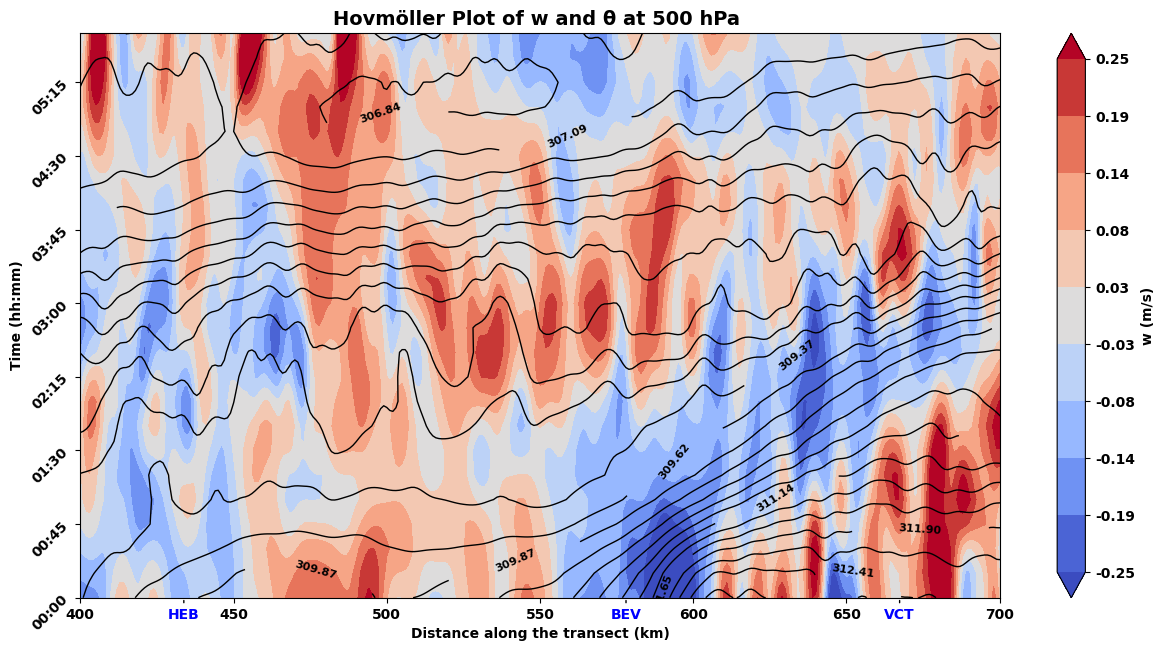

In [58]:
from wrf import ll_to_xy
from geopy.distance import geodesic

start_coord = (25.50, -102.50)
end_coord = (29.75, -95.36)
start_vct = (28.822003, -96.983117)
start_bee = (28.39, -97.740)
start_heb = (27.30, -98.70)

fig, ax = plt.subplots(figsize=(12, 6))
levels = np.linspace(-0.25, 0.25, 10) 
levels2 = np.linspace(300,320, 80)  # 100 levels from -0.6 to 0.6
contour = ax.contourf(w_500_smoothened, cmap='coolwarm', levels=levels,extend='both')
contour2 = ax.contour(theta_500_smoothened, levels=levels2, colors='black', linewidths=1, extend='both')
clabels = ax.clabel(contour2, inline=True, fontsize=8, fmt='%1.2f', colors='black')

plt.yticks(
    ticks=np.arange(0, len(t_plot), 3),  
    labels=[t.time().strftime('%H:%M') for t in t_plot[::3]],  
    rotation=45
)

vct_lat, vct_lon = 28.822003, -96.983117
total_distance_km = geodesic(start_coord, end_coord).kilometers
vct_distance_km = geodesic(start_coord,start_vct).kilometers  
print(vct_distance_km)
vct_x_position = (vct_distance_km/total_distance_km) * w_500_smoothened.shape[1] # Calculate the distance along the transect that is used to scale the x-axis
ax.annotate('VCT', 
            xy=(vct_x_position, ax.get_ylim()[0]),  
            xytext=(vct_x_position, ax.get_ylim()[0] - 1),
            textcoords="data", ha='center', va='bottom', 
            fontsize=10, color="blue",
            arrowprops=dict(arrowstyle='-', color='black'))


bev_distance_km = geodesic(start_coord,start_bee).kilometers
bev_x_position = (bev_distance_km / total_distance_km) * w_500_smoothened.shape[1]
ax.annotate('BEV', 
            xy=(bev_x_position, ax.get_ylim()[0]),  
            xytext=(bev_x_position, ax.get_ylim()[0] - 1),
            textcoords="data", ha='center', va='bottom', 
            fontsize=10, color="blue",
            arrowprops=dict(arrowstyle='-', color='black'))


heb_lat,heb_lon =27.30, -98.70
heb_distance_km = geodesic(start_coord,start_heb).kilometers
heb_x_position = (heb_distance_km / total_distance_km) * w_500_smoothened.shape[1]
ax.annotate('HEB', 
            xy=(heb_x_position, ax.get_ylim()[0]),  
            xytext=(heb_x_position, ax.get_ylim()[0] - 1),
            textcoords="data", ha='center', va='bottom', 
            fontsize=10, color="blue",
            arrowprops=dict(arrowstyle='-', color='black'))

ax.set_xlim(400,700)
ax.set_ylim(0, len(t_plot)-10)

plt.rcParams.update({
'font.size': 10,
'font.weight': 'bold',
'axes.labelsize': 10,
'axes.labelweight': 'bold',
'axes.titlesize': 14,
'axes.titleweight': 'bold'
})


from matplotlib.ticker import FormatStrFormatter
cbar = plt.colorbar(contour, label='w (m/s)')
cbar.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.tight_layout(pad=0) 
plt.xlabel('Distance along the transect (km)')
plt.ylabel('Time (hh:mm)')
plt.title('Hovmöller Plot of w and θ at 500 hPa ')
plt.show()

In [29]:
print("w_500_array.shape")
print(w_500_smoothened.shape)

w_500_array.shape
(33, 858)


argrelextrema(...)	Finds relative extrema (peaks or troughs) in the array.
- np.greater	Specifies you're looking for local maxima (crests). Use np.less for minima (troughs).
- order=5	Requires each maximum to be greater than its 5 neighbors on both sides — this reduces false peaks and controls smoothness/sensitivity.
- [0]	Extracts the index array of local maxima (positions of crests).

In [ ]:
from scipy.signal import argrelextrema
w_500_array = np.array(w_500_smoothened)
time_steps, transect_points = w_500_array.shape

crest_distances = []  # Stores x-axis positions (distance along transect)
crest_times = []      # Stores y-axis positions (time steps)

for i in range(transect_points):
    crests_indices = argrelextrema(w_500_array[:, i], np.greater, order=5)[0]  
    for crest_time in crests_indices:
        crest_distances.append(i)  # Transect point index
        crest_times.append(crest_time)  # Time step index
crest_distances = np.array(crest_distances)
crest_times = np.array(crest_times)



'''trough_distances = []  # Stores x-axis positions (distance along transect)
trough_times = []      # Stores y-axis positions (time steps)
for i in range(transect_points):
    trough_indices = argrelextrema(w_500_array[:, i], np.less, order=5)[0]  # Local minima
    for trough_time in trough_indices:
        trough_distances.append(i)       # Transect point index
        trough_times.append(trough_time) # Time step index
trough_distances = np.array(trough_distances)
trough_times = np.array(trough_times)'''


poly_fit = [m, b]
poly_fit[0] = You're extracting the slope (m)

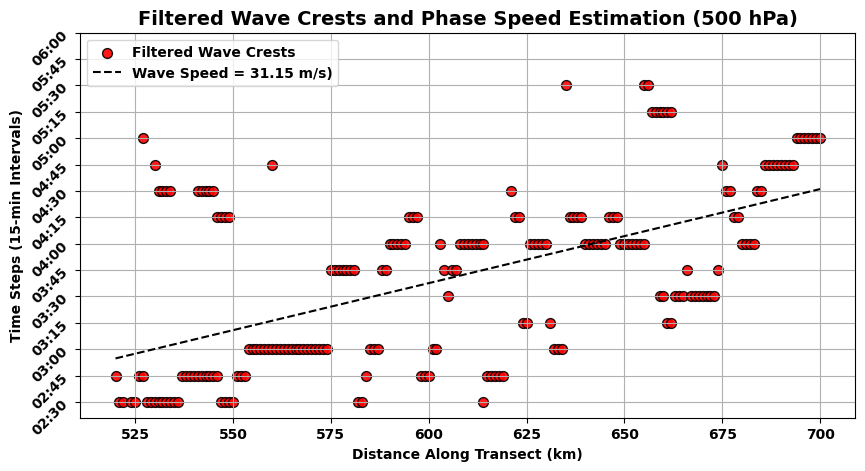

In [99]:
# Sub region: decide this based on the hovmoller plot
valid_distance_range = (520, 700) 
valid_time_range = (10, 22)

# Filter
filtered_crests = [(d, t) for d, t in zip(crest_distances, crest_times)
                   if valid_distance_range[0] <= d <= valid_distance_range[1] and
                   valid_time_range[0] <= t <= valid_time_range[1]]

filtered_distances = np.array([d for d, t in filtered_crests])
filtered_times = np.array([t for d, t in filtered_crests])

'''# Filter troughs
filtered_troughs = [(d, t) for d, t in zip(trough_distances, trough_times)
                    if valid_distance_range[0] <= d <= valid_distance_range[1] and
                    valid_time_range[0] <= t <= valid_time_range[1]]

filtered_trough_distances = np.array([d for d, t in filtered_troughs])
filtered_trough_times = np.array([t for d, t in filtered_troughs])'''

# Ensure we have enough points for fitting and calculate wave speed in m/s
if len(filtered_distances) > 7:
    poly_fit = np.polyfit(filtered_distances, filtered_times, 1)
    wave_speed = (1 / poly_fit[0]) * (1000 / (15 * 60))
else:
    print("Not enough valid crest points for fitting.")
    wave_speed = np.nan



# Plot the crests and the best-fit line
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(filtered_distances, filtered_times, facecolor='red',
    edgecolor='black',       # Border color
    linewidth=1,             # Thickness of border
    s=50,                    # Size of marker
    alpha=0.9,
    marker='o',
    label="Filtered Wave Crests")

ax.set_yticks(filtered_times)
ax.plot(filtered_distances, np.polyval(poly_fit, filtered_distances), 'k--', label=f"Wave Speed = {wave_speed:.2f} m/s)")
# Labels and styling
plt.yticks(
    ticks=np.arange(10, 25, 1),  
    labels=[t.time().strftime('%H:%M') for t in t_plot[10:25]],  
    rotation=45
)
ax.set_xlabel("Distance Along Transect (km)")
ax.set_ylabel("Time Steps (15-min Intervals)")
ax.set_title("Filtered Wave Crests and Phase Speed Estimation (500 hPa)")
ax.legend()
ax.grid(True)

plt.show()